In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp

# Constants
G = 6.67430e-11            # gravitational constant, m^3 kg^-1 s^-2
M_earth = 5.972e24         # mass of Earth in kg
R_earth = 6.371e6          # radius of Earth in meters


## 🚀 Rocket Simulation


### Newton's Law of Gravitation:

$ \vec{F} = -\frac{GMm}{r^{2}}\hat{r}$

where:

$G$ is Newton's Gravitational Constant, 

$M$ is the mass of the Earth, 

$m$ is the mass of the projectile, 

$r$ is the distance from Earth's centre. 


### Newton's Second Law:

$ \vec{a} = \frac{\vec{F}}{m} = -\frac{GM}{r^{2}}\hat{r}$

The acceleration of the projectile therefore is idependent of its mass. 

### Equations of motion:


$ \frac{d\vec{r}}{dt} = \vec{v},  \frac{d\vec{v}}{dt} = -\frac{GM}{r^{3}}\hat{r}$


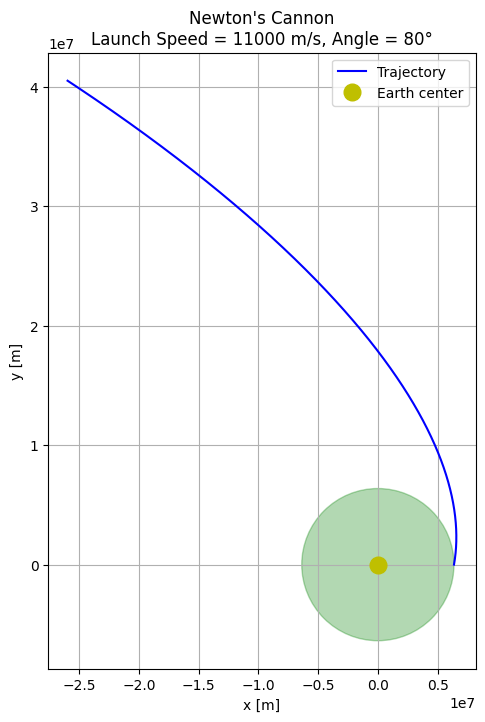

In [9]:
# Launch parameters
altitude = 2000 
launch_angle_deg = 80  # angle from horizontal
launch_speed = 11000    # m/s

# Convert angle to radians
theta = np.radians(launch_angle_deg)

# Initial position (from center of Earth)
r0 = R_earth + altitude
x0 = r0
y0 = 0

# Initial velocity components
vx0 = 0
vy0 = launch_speed

# Rotate velocity vector to match angle
vx = launch_speed * np.cos(theta)
vy = launch_speed * np.sin(theta)

# Define Initial state vector
y_init = [x0, y0, vx, vy]


# Time span
t_max = 10000  # seconds
t_eval = np.linspace(0, t_max, 2000)

# Define a separate event function
def hit_earth_event(t, y, G, M):
    r = np.sqrt(y[0]**2 + y[1]**2)
    return r - R_earth  # triggers when r = R_earth

hit_earth_event.terminal = True  # stop the integration
hit_earth_event.direction = -1   # only trigger when approaching Earth

def cannon(t, y, G, M):  # Function defining Newton's 2nd law as a system of ODEs
    rx, ry, vx, vy = y 
    r = np.sqrt(rx**2 + ry**2)
    ax = -G * M * rx / r**3
    ay = -G * M * ry / r**3
    return [vx, vy, ax, ay]


sol = solve_ivp(        #initial value problem solver which integrates the ODEs      
    cannon,
    [0, t_max],
    y_init,
    t_eval=t_eval,
    args=(G, M_earth),
    rtol=1e-8,
    events=hit_earth_event  # end point
)


x = sol.y[0] # x position determined by the ODE solver
y = sol.y[1] # y position determined by the ODE solver


# Plot the result
fig, ax = plt.subplots(figsize=(8, 8))
ax.plot(x, y, label="Trajectory", color='blue')
ax.plot(0, 0, 'yo', markersize=12, label="Earth center")

# Draw Earth
earth = plt.Circle((0, 0), R_earth, color='green', alpha=0.3)
ax.add_patch(earth)# Define a separate event function

ax.set_aspect('equal')
ax.set_xlabel("x [m]")
ax.set_ylabel("y [m]")
ax.set_title(f"Newton's Cannon\nLaunch Speed = {launch_speed} m/s, Angle = {launch_angle_deg}°")
ax.grid(True)
ax.legend()
plt.show()


Exercise ideas:

- Vary initial conditions - play around with it
- Escape velocity (make a function defining it - ask students to verify)
- Plotting energy over time (KE, PE)
- Introduction air resistance, and compare plots?
- Circular orbits